In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

import scikitplot as skplt
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [4]:
df= pd.read_csv('data/moral_appeal_dataset.csv')
df

,ad,moral_appeal
0,psd jobs spring launch webinar monday pmpm vir...,0
1,the aflcio has always fought alongside workers...,1
2,your national monuments are on the chopping block,0
3,join us for a focus group to share your though...,0
4,with president trump nominating a judge with a...,1
...,...,...
19729,what is senator heidi heitkamp hiding watch be...,0
19730,breaking the washington post just reported on ...,0
19731,protecting vermont is injured employees contac...,1
19732,according to the huffington post days after pa...,0


In [5]:
# vectorize testing and training data 
X_train, X_test, y_train, y_test= train_test_split(df['ad'], df['moral_appeal'] , test_size = 0.2, random_state = 0)

In [6]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('prevaccine', 37760), ('<PAD>', 0), 1)

In [7]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

In [8]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((15787, 1000), (3947, 1000))

In [9]:
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K


class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
            Attention Layer sourced from : https://github.com/lzfelix/keras_attention/blob/master/attention/layers.py

            Implementation based in the work of Yang et al. "Hierarchical Attention Networks for Document Classification". 
            This implementation also allows changing the common tanh activation function used on the attention layer, as Chen
            et al. "A Thorough Examination of the CNN/Daily Mail Reading Comprehension Task"
            point that removing this component can be beneficial to the model. Supports
            masking.
    
            The mathematical formulation of the model is as follows:
              ```
              u = f(W * h + b),
              a_i = softmax(u_i^T * u_s),
              v_i = \sigma_i a_i * h_i.
              ```
    
            # Arguments
                  activation: The activation function f used by the layer (see
                      [activations](../activations.md)). By default tanh is used, another common
                      option is "linear".
                  use_bias: Boolean, whether the layer uses a bias vector.
                  initializer: Initializer for the `kernel` and `context` matrices
                      (see [initializers](../initializers.md)).
                  return_attention: If True, instead of returning the sequence descriptor, this
                      layer will return the computed attention coefficients for each of the
                      sequence timesteps. See Output section for details.
                  W_regularizer: Regularizer function applied to the `kernel` weights matrix
                      (see [regularizer](../regularizers.md)).
                  u_regularizer: Regularizer function applied to the `context` weights matrix
                      (see [regularizer](../regularizers.md)).
                  b_regularizer: Regularizer function applied to the bias vector
                      (see [regularizer](../regularizers.md)).
                  W_constraint: Constraint function applied to the `kernel` weights matrix
                      (see [constraints](../constraints.md)).
                  u_constraint: Constraint function applied to the `contextl` weights matrix
                      (see [constraints](../constraints.md)).
                  b_constraint: Constraint function applied to the bias vector
                      (see [constraints](../constraints.md)).
          # Input shape
                  nD tensor with shape: `(batch_size, ..., timesteps, input_dim)`.
                  The most common situation would be a 3D input with shape
                  `(batch_size, timesteps, input_dim)`.
          # Outuput shape
                  The sequence descriptor with shape `(batch_size, ..., timestamps)`. If
                  `return_attention` is True, this layer will return the `alpha_i` weights
                  for each timestep, and consequently its output shape will be different, namely:
                  `(batch_size, ..., timesteps)`. 
        """
        
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape= (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
def create_model(vocab_size, embedding_dim, max_sequence_length, gru_dim,dropout = 0.2):
  '''
    Create a Bidirectional GRU used for binary text classification task
    Arguments : 
      vocab_size: vocabulary size 
      embedding_dim: embedding dimensions for the document vector representation 
      max_sequence_length: input sequence length for each document 
      gru_dim: number of neurones in the GRU layers
      dropout : dropout rate used for Dropout regularization layers to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - Input layer to instantiate a tensor using the input preprocessed data
            - Embedding layer to represent each document with a context vector
            - Biderectional GRU (takes into consideration bidrectional context)
            - A custom attention layer that takes **all** of the output of the GRU ( not the last hidden state only)
            - Dense layer 
            - Dropout layer to minimize overfitting
            - A Dense layer 
            - Dropout 
            - An output layer to get the label of the class 
  '''
  model = Sequential([
      layers.Input(shape=(max_sequence_length,)),
      layers.Embedding(vocab_size, embedding_dim, trainable=True),
      layers.Bidirectional(layers.GRU(gru_dim, return_sequences=True)),
      AttentionLayer(max_sequence_length),
      layers.Dense(gru_dim*2, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(gru_dim, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [11]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units
VOCAB_SIZE = len(t.word_index)

# Create the model
model = create_model(vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, max_sequence_length = MAX_SEQUENCE_LENGTH, gru_dim = GRU_DIM)

model.summary()

2022-06-02 18:48:00.819373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 18:48:01.484178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10417 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         4833408   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 256)        198144    
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 256)              1256      
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [12]:
# model training 
batch_size = 32
model.fit(X_train, y_train, epochs= 5, batch_size=batch_size, 
          shuffle=True, validation_split=0.2, verbose=1      )

Epoch 1/5


2022-06-02 18:48:08.948799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


395/395 [==============================] - 31s 68ms/step - loss: 0.2242 - accuracy: 0.8829 - val_loss: 0.0166 - val_accuracy: 0.9962
Epoch 2/5
395/395 [==============================] - 26s 67ms/step - loss: 0.0174 - accuracy: 0.9971 - val_loss: 0.0153 - val_accuracy: 0.9972
Epoch 3/5
395/395 [==============================] - 26s 67ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.0337 - val_accuracy: 0.9918
Epoch 4/5
395/395 [==============================] - 27s 68ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0239 - val_accuracy: 0.9981
Epoch 5/5
395/395 [==============================] - 27s 67ms/step - loss: 7.5555e-04 - accuracy: 0.9997 - val_loss: 0.0545 - val_accuracy: 0.9937


124/124 [==============================] - 3s 28ms/step - loss: 0.0453 - accuracy: 0.9959
Accuracy: 99.59%
124/124 [==============================] - 4s 24ms/step
                 precision    recall  f1-score   support

no moral appeal       0.99      1.00      1.00      1934
   moral appeal       1.00      1.00      1.00      2013

       accuracy                           1.00      3947
      macro avg       1.00      1.00      1.00      3947
   weighted avg       1.00      1.00      1.00      3947

confusion matrix:
[[1928    6]
 [  10 2003]]



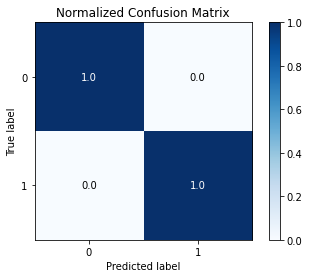

In [13]:
from sklearn import metrics

# get model predictions 
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]


print(metrics.classification_report(y_test, predictions, target_names=['no moral appeal', 'moral appeal']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [15]:
# save the test results 
save = pd.read_csv('data/sample_moral_appeal.csv')
save

,ad,moral
0,yearold danylo is not only battling cancer but...,1
1,learn how to use the new staffing law to impro...,0
2,we are live with climate activist anuna de wev...,0
3,did you miss the t summit relive the daylong e...,0
4,friday is north carolinas online voter registr...,0
...,...,...
195,you can make a difference this year donate now...,1
196,dear readers\nrussian nazis do not stop exterm...,1
197,education risks becoming the greatest divider ...,1
198,shelling killed her mother\nwithout an urgent ...,1


7/7 [==============================] - 0s 26ms/step - loss: 9.3799 - accuracy: 0.6200
Accuracy: 62.00%
7/7 [==============================] - 0s 24ms/step
confusion matrix:
[[28 73]
 [ 3 96]]



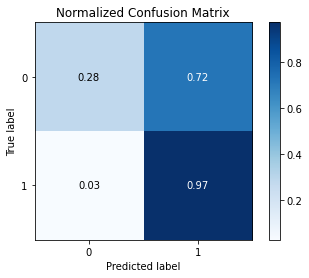

                 precision    recall  f1-score   support

no moral appeal       0.90      0.28      0.42       101
   moral appeal       0.57      0.97      0.72        99

       accuracy                           0.62       200
      macro avg       0.74      0.62      0.57       200
   weighted avg       0.74      0.62      0.57       200



In [17]:
norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

scores = model.evaluate(padded_, save['moral'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

val_ = t.texts_to_sequences(norm_)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_, maxlen=MAX_SEQUENCE_LENGTH)
pred_ =  model.predict(padded_val)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(save['moral'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['moral'], save['predicted'], normalize=True)
plt.show()

print(metrics.classification_report(save['moral'], save['predicted'], target_names=[ 'no moral appeal', 'moral appeal']))